In [1]:
import numpy as np
import torch
from torchvision.datasets import mnist
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from tensorboardX import SummaryWriter

In [2]:
# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20

In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

In [4]:
#定义预处理函数
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
#下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('./mnistdata', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('./mnistdata', train=False, transform=transform)
#得到一个生成器
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)#shuffle,以便在每个epoch重新洗牌数据(
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
example_data.shape,example_targets.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

torch.Size([128, 784])

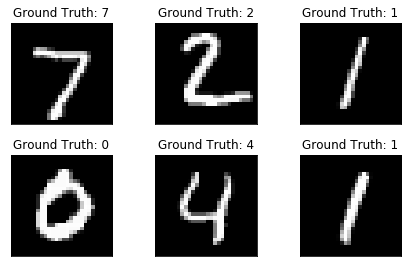

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none') #interplotation：默认"None"，可用字符串类型命令设定
    #- cmap：默认"None"，可设为 “colormap"
    #如果是“None”，默认rc值符合 image.cmap 。如果X是3-D，则cmap会被忽略，而采用 具体的RGB(A)值。
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
example_data = example_data.view(example_data.size(0), -1)
example_data.shape

In [8]:
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1),nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2),nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
        
 
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [9]:
lr = 0.01
momentum = 0.9

In [10]:
torch.cuda.is_available()

True

In [11]:
#实例化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#if torch.cuda.device_count() > 1:
#    print("Let's use", torch.cuda.device_count(), "GPUs")
#    # dim = 0 [20, xxx] -> [10, ...], [10, ...] on 2GPUs
#    model = nn.DataParallel(model)
model = Net(28 * 28, 300, 100, 10)
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [14]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []
writer = SummaryWriter(log_dir='logs',comment='train-loss')

for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    #动态修改参数学习率
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.9
        print(optimizer.param_groups[0]['lr'])
    for img, label in train_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        # 前向传播
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 保存loss的数据与epoch数值
        writer.add_scalar('Train', train_loss/len(train_loader), epoch)
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    #net.eval() # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader), 
                     eval_loss / len(test_loader), eval_acc / len(test_loader)))

0.008100000000000001
<built-in method max of Tensor object at 0x7eff9d8383a8>
epoch: 0, Train Loss: 0.2880, Train Acc: 0.9235, Test Loss: 0.1109, Test Acc: 0.9677
<built-in method max of Tensor object at 0x7eff9d8383a8>
epoch: 1, Train Loss: 0.0974, Train Acc: 0.9707, Test Loss: 0.0813, Test Acc: 0.9769
<built-in method max of Tensor object at 0x7eff9d838d38>
epoch: 2, Train Loss: 0.0683, Train Acc: 0.9796, Test Loss: 0.0695, Test Acc: 0.9793
<built-in method max of Tensor object at 0x7eff9d838240>
epoch: 3, Train Loss: 0.0507, Train Acc: 0.9844, Test Loss: 0.0659, Test Acc: 0.9793
<built-in method max of Tensor object at 0x7eff9d838fc0>
epoch: 4, Train Loss: 0.0402, Train Acc: 0.9875, Test Loss: 0.0635, Test Acc: 0.9804
0.007290000000000001
<built-in method max of Tensor object at 0x7eff9d8383a8>
epoch: 5, Train Loss: 0.0299, Train Acc: 0.9911, Test Loss: 0.0602, Test Acc: 0.9818
<built-in method max of Tensor object at 0x7eff9d838ab0>
epoch: 6, Train Loss: 0.0240, Train Acc: 0.9929, 

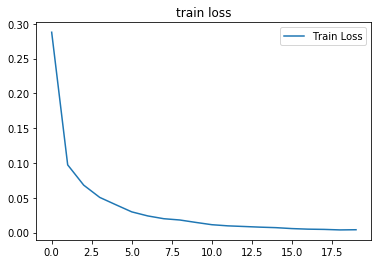

In [15]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
#plt.plot(np.arange(len(eval_losses)), eval_losses)
#plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.legend(['Train Loss'], loc='upper right')